<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/DR-stage-identification/DR_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Feature Extraction

In [ ]:
# Dataset Paths
DATASET_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset"
TRAIN_CSV = os.path.join(DATASET_DIR, "train.csv")
VAL_CSV = os.path.join(DATASET_DIR, "validation.csv")
TEST_CSV = os.path.join(DATASET_DIR, "test.csv")

TRAIN_DIR = os.path.join(DATASET_DIR, "Train_Images")
VAL_DIR = os.path.join(DATASET_DIR, "Validation_Images")
TEST_DIR = os.path.join(DATASET_DIR, "Test_Images")

# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure images have ".png" extension
train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
val_df['id_code'] = val_df['id_code'].astype(str) + ".png"
test_df['id_code'] = test_df['id_code'].astype(str) + ".png"

# Diagnosis Mapping
diagnosis_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR",
}

train_df['diagnosis'] = train_df['diagnosis'].astype(int).map(diagnosis_mapping)
val_df['diagnosis'] = val_df['diagnosis'].astype(int).map(diagnosis_mapping)
test_df['diagnosis'] = test_df['diagnosis'].astype(int).map(diagnosis_mapping)

# Image Preprocessing
IMG_SIZE = (224, 224)  # VGG16 and EfficientNetB0 require 224x224
BATCH_SIZE = 32

# Create separate ImageDataGenerators for each model with their respective preprocessing functions
train_datagen_vgg = ImageDataGenerator(preprocessing_function=vgg16_preprocess)
train_datagen_eff = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

val_test_datagen_vgg = ImageDataGenerator(preprocessing_function=vgg16_preprocess)
val_test_datagen_eff = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generators for VGG16
train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

val_generator_vgg = val_test_datagen_vgg.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_vgg = val_test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Generators for EfficientNetB0
train_generator_eff = train_datagen_eff.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

val_generator_eff = val_test_datagen_eff.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_eff = val_test_datagen_eff.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data Generators Initialized.")

# Load VGG16 and EfficientNetB0 for Feature Extraction
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base models
vgg_base.trainable = False
effnet_base.trainable = False

# Function to extract features
def extract_features(model, generator, num_samples):
    """Extracts features using a given model."""
    steps = int(np.ceil(num_samples / BATCH_SIZE))
    features = model.predict(generator, steps=steps, verbose=1)
    return features

# Extract Features using VGG16
print("Extracting Features using VGG16...")
train_features_vgg = extract_features(vgg_base, train_generator_vgg, len(train_df))
val_features_vgg = extract_features(vgg_base, val_generator_vgg, len(val_df))
test_features_vgg = extract_features(vgg_base, test_generator_vgg, len(test_df))

# Extract Features using EfficientNetB0
print("Extracting Features using EfficientNetB0...")
train_features_eff = extract_features(effnet_base, train_generator_eff, len(train_df))
val_features_eff = extract_features(effnet_base, val_generator_eff, len(val_df))
test_features_eff = extract_features(effnet_base, test_generator_eff, len(test_df))

# Save extracted features
np.save("train_features_vgg.npy", train_features_vgg)
np.save("val_features_vgg.npy", val_features_vgg)
np.save("test_features_vgg.npy", test_features_vgg)

np.save("train_features_eff.npy", train_features_eff)
np.save("val_features_eff.npy", val_features_eff)
np.save("test_features_eff.npy", test_features_eff)

# Save labels
train_labels = to_categorical(train_generator_vgg.classes, num_classes=5)
val_labels = to_categorical(val_generator_vgg.classes, num_classes=5)
test_labels = to_categorical(test_generator_vgg.classes, num_classes=5)

np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)
np.save("test_labels.npy", test_labels)

print("Feature Extraction Complete.")

Found 3528 validated image filenames belonging to 5 classes.
Found 757 validated image filenames belonging to 5 classes.
Found 756 validated image filenames belonging to 5 classes.
Found 3528 validated image filenames belonging to 5 classes.
Found 757 validated image filenames belonging to 5 classes.
Found 756 validated image filenames belonging to 5 classes.
Data Generators Initialized.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting Features using VGG16...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 2946s 27s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 592s 26s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 588s 26s/step
Extracting Features using EfficientNetB0...
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step
Feature Extraction Complete.


### Model Building

In [ ]:
# Load extracted features
train_features_vgg = np.load("train_features_vgg.npy")
val_features_vgg = np.load("val_features_vgg.npy")
test_features_vgg = np.load("test_features_vgg.npy")

train_features_eff = np.load("train_features_eff.npy")
val_features_eff = np.load("val_features_eff.npy")
test_features_eff = np.load("test_features_eff.npy")

# Load labels
train_labels = np.load("train_labels.npy")
val_labels = np.load("val_labels.npy")
test_labels = np.load("test_labels.npy")

# Concatenate features from both models
train_features = np.concatenate((train_features_vgg.reshape(len(train_features_vgg), -1),
                                 train_features_eff.reshape(len(train_features_eff), -1)), axis=1)

val_features = np.concatenate((val_features_vgg.reshape(len(val_features_vgg), -1),
                               val_features_eff.reshape(len(val_features_eff), -1)), axis=1)

test_features = np.concatenate((test_features_vgg.reshape(len(test_features_vgg), -1),
                                test_features_eff.reshape(len(test_features_eff), -1)), axis=1)

# Define Fully Connected Classifier
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(train_features.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels, epochs=50, validation_data=(val_features, val_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.3430 - loss: 5.5119 - val_accuracy: 0.5905 - val_loss: 1.0909
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4674 - loss: 1.3897 - val_accuracy: 0.5773 - val_loss: 1.1141
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5341 - loss: 1.2285 - val_accuracy: 0.6830 - val_loss: 0.9522
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5899 - loss: 1.0746 - val_accuracy: 0.6803 - val_loss: 0.9253
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6393 - loss: 0.9718 - val_accuracy: 0.7067 - val_loss: 0.9142
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6516 - loss: 0.9490 - val_accuracy: 0.7028 - val_loss: 0.8957
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6811 - loss: 0.8618 - val_accuracy: 0.7305 - val_loss: 0.8178
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7224 - loss: 0.7320 - val_accu

### Save Model

In [ ]:
# Save the trained classifier to the specified drive directory
model_save_path = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/diabetic_retinopathy_final_model.h5"
model.save(model_save_path)

### Model Evaluation

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


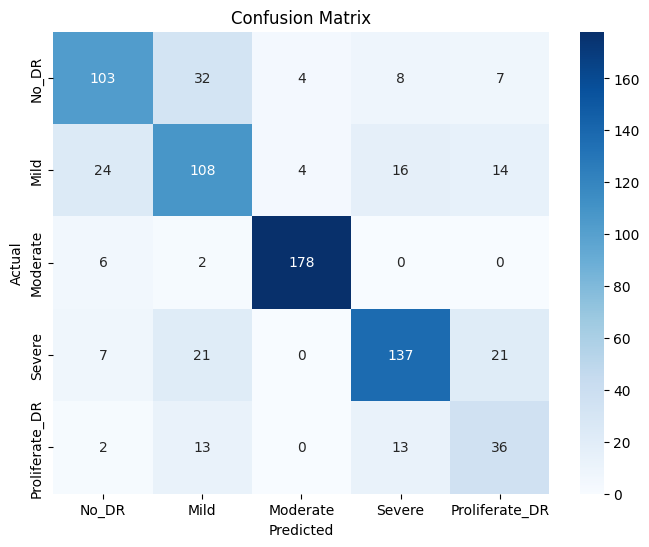

Classification Report:
                 precision    recall  f1-score   support

         No_DR       0.73      0.67      0.70       154
          Mild       0.61      0.65      0.63       166
      Moderate       0.96      0.96      0.96       186
        Severe       0.79      0.74      0.76       186
Proliferate_DR       0.46      0.56      0.51        64

      accuracy                           0.74       756
     macro avg       0.71      0.72      0.71       756
  weighted avg       0.75      0.74      0.75       756



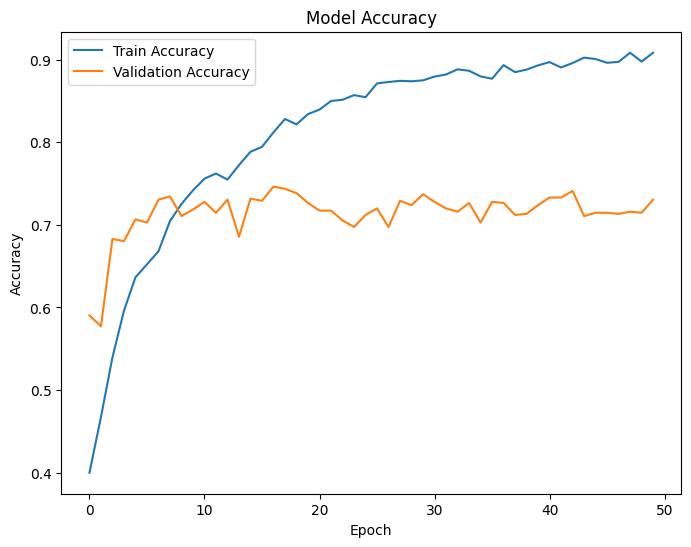

In [ ]:
# Load the trained model
model = tf.keras.models.load_model(model_save_path)

# Load test features (reloading individual feature files and concatenating them)
test_features_vgg = np.load("test_features_vgg.npy")
test_features_eff = np.load("test_features_eff.npy")
test_features = np.concatenate((test_features_vgg.reshape(len(test_features_vgg), -1),
                                test_features_eff.reshape(len(test_features_eff), -1)), axis=1)

test_labels = np.load("test_labels.npy")

# Predict on the test set
predictions = model.predict(test_features)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Define class labels
class_labels = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate and display Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", class_report)

# Plot Training vs. Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()